# Morpion Solitaire: exploration with a model

In [1]:
import sys, os
sys.path.append(os.getcwd() + '/../cpp/bin')

import PyMorpionSolitaire

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [4]:
# from multiprocess import Pool
# pool = Pool(10)

## Model

In [5]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

In [6]:
# net = torch.load('models/model-32.pt', map_location=device)
net = torch.load('models/model-128.pt', map_location=device)
net.eval()

Sequential(
  (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=128, out_features=32, bias=True)
  (13): ReLU()
  (14): Linear(in_features=32, out_features=8, bias=True)
  (15): ReLU()
  (16): Linear(in_features=8, out_features=1, bias=True)
)

## Game

In [7]:
game = PyMorpionSolitaire.Game5T('c')

In [8]:
state = game.image()[48:144, 48:144]
actions = game.getMoveImages()[:, 48:144, 48:144]

state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
actions = actions ^ state

x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
x.shape

torch.Size([28, 2, 96, 96])

In [9]:
with torch.no_grad():
    y = net(x).data

In [10]:
y.min().item(), y.mean().item(), y.max().item()

(-0.0028589963912963867, 0.0030934747774153948, 0.007987916469573975)

In [11]:
game = PyMorpionSolitaire.Game5T('c')

with torch.no_grad():
    while game.getNumberOfMoves() > 0:
        state = game.image()[48:144, 48:144]
        actions = game.getMoveImages()[:, 48:144, 48:144]
        
        state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
        actions = actions ^ state
        
        x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
        y = net(x).data.squeeze(1)
        i = np.argmax(y).item()
        s = game.getScore()
        game.playByIndex(i)
        print("%3d %7.3f %7.3f %7.3f" % (s, y.min().item(), y.mean().item(), y[i].item()))

  0  -0.003   0.003   0.008
  1  -0.004   0.003   0.008
  2  -0.004   0.003   0.008
  3  -0.002   0.004   0.009
  4  -0.003   0.002   0.006
  5  -0.004   0.004   0.010
  6  -0.001   0.003   0.005
  7  -0.001   0.003   0.008
  8  -0.001   0.004   0.007
  9  -0.001   0.003   0.007
 10  -0.004   0.002   0.006
 11  -0.002   0.002   0.006
 12  -0.001   0.002   0.005
 13  -0.001   0.002   0.004
 14  -0.008   0.002   0.007
 15  -0.007   0.002   0.006
 16  -0.004   0.001   0.006
 17  -0.009  -0.000   0.007
 18  -0.006  -0.000   0.006
 19  -0.009  -0.001   0.012
 20  -0.007  -0.000   0.007
 21  -0.005   0.001   0.010
 22  -0.004   0.002   0.010
 23  -0.004   0.001   0.008
 24  -0.001   0.003   0.007
 25  -0.005   0.004   0.010
 26  -0.004   0.004   0.010
 27  -0.001   0.003   0.009
 28  -0.001   0.003   0.005
 29  -0.001   0.001   0.002
 30  -0.001   0.000   0.002
 31  -0.005   0.001   0.008
 32  -0.005   0.002   0.009
 33  -0.005   0.003   0.008
 34  -0.005   0.004   0.010
 35  -0.003   0.003 

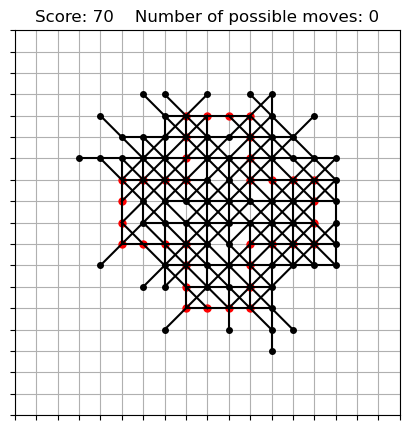

In [12]:
game.print()

In [13]:
def play(t):
    game = PyMorpionSolitaire.Game5T('c')
    while True:
        n = game.getNumberOfMoves()
        if n == 0:
            return game.getScore()
        if n == 1:
            game.playByIndex(0)
        else:
            state = game.image()[48:144, 48:144]
            actions = game.getMoveImages()[:, 48:144, 48:144]
            
            state = np.expand_dims(state, 0).repeat(actions.shape[0], axis=0)
            actions = actions ^ state
            
            x = torch.tensor(np.concatenate([np.expand_dims(state, 1), np.expand_dims(actions, 1)], axis = 1)).float()
            y = net(x).data.squeeze()
            p = torch.exp(y / t)
            p /= p.sum()
            index = np.random.choice(range(len(p)), p=np.array(p))
            game.playByIndex(index)

In [14]:
# def play_parallel(t, n):
#     return pool.map(play, [t for _ in range(n)])

In [15]:
scores = {
    t: [play(t) for _ in tqdm(range(100), position=1, leave=False)] for t in tqdm([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10], position=0)
}

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
def play_random():
    game = PyMorpionSolitaire.Game5T('c')
    game.playAtRandom()
    return game.getScore()

In [17]:
scores[100] = [play_random() for _ in trange(100000)]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [18]:
scores_mean = {t: np.mean(score).item() for t, score in scores.items()}
scores_mean

{0.02: 63.0,
 0.05: 64.01,
 0.1: 63.16,
 0.2: 61.91,
 0.5: 59.92,
 1: 56.65,
 2: 53.46,
 5: 52.12,
 10: 54.45,
 100: 53.61866}

In [19]:
scores_max = {t: np.max(score).item() for t, score in scores.items()}
scores_max

{0.02: 78,
 0.05: 80,
 0.1: 75,
 0.2: 78,
 0.5: 74,
 1: 82,
 2: 80,
 5: 72,
 10: 76,
 100: 88}

In [20]:
x = list(scores_mean.keys())

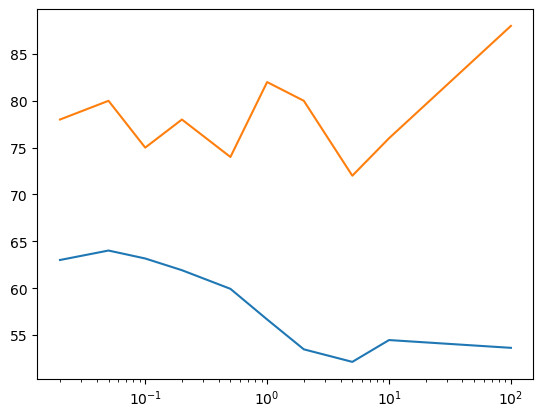

In [21]:
plt.plot(x, [scores_mean[i] for i in x], label="mean")
plt.plot(x, [scores_max[i] for i in x], label="max")
plt.xscale('log')
plt.show()

In [24]:
# scores[0.1] = scores[0.1] + [play(0.1) for _ in trange(900)]

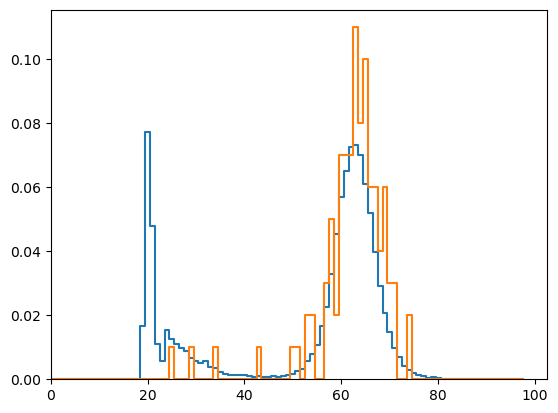

In [25]:
bins = [i - 0.5 for i in range(100)]

dist_0, bins = np.histogram(scores[100], bins, density=True)
dist, bins = np.histogram(scores[0.1], bins, density=True)

plt.step(bins[:-1], dist_0)
plt.step(bins[:-1], dist)
plt.xlim(0)
plt.ylim(0)
plt.show()